In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
# %pip install python-terrier
import pyterrier as pt
import os
import seaborn as sns
from pyterrier.measures import *
from sklearn.ensemble import RandomForestRegressor
import fastrank
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.metrics import average_precision_score, ndcg_scor

/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not pt.started():
  pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
# Load in full data file + testing file
sephora = pd.read_csv('sephora_final_subset.csv')
sephora.head()

,docno,brand,category,name,size,rating,number_of_reviews,love,price,value_price,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2222917,Acqua Di Parma,Body Lotions & Body Oils,Fico di Amalfi Spray Body Lotion,5 oz/150 mL,3.0,2,420,55.0,55.0,no options,Fragrance Family: FloralScent Type: Fruity Flo...,Suggested Usage:-Spray generously onto clean s...,-Almond Oil- Olive Oil- and Grapeseed Oil: Hyd...,1,0,0,0
1,2222909,Acqua Di Parma,Body Lotions & Body Oils,Arancia di Capri Spray Body Lotion,5 oz/150 mL,3.0,2,444,55.0,55.0,no options,Fragrance Family: FreshScent Type: Fresh Citru...,Suggested Usage:-Spray generously onto clean s...,-Almond Oil- Olive Oil- and Grapeseed Oil: Hyd...,1,0,0,0
2,2317907,AERIN,no category,Wild Geranium,0.27 oz/ 8 mL,0.0,0,108,30.0,30.0,- 1.7 oz/ 50 mL Eau de Parfum Spray - 3.4 oz/ ...,Fragrance Family: FloralsScent Type: Fresh Flo...,Suggested Usage:-Fragrance is intensified by t...,Alcohol Denat.- Fragrance (Parfum)- Water\Aqua...,1,0,0,0
3,1738640,AERIN,Lip Balm & Treatment,Rose Lip Conditioner,0.34 oz/ 10 mL,4.5,386,17000,30.0,30.0,no options,What it is: A nurturing lip conditioner with ...,no instructions,Polybutene; Hydrogenated Polyisobutene; Dextri...,1,0,0,0
4,1736065,AERIN,Lotions & Oils,Waterlily Sun Body Cream,1 oz / 30 mL,5.0,4,961,15.0,15.0,no options,What it is:\n A richly luxurious and deeply re...,no instructions,unknown,0,0,0,0


In [4]:
sephora.shape

(3439, 18)

In [5]:
qrels = pd.read_csv('query_rels.csv')
qrels.dtypes

qid      float64
docno      int64
label      int64
dtype: object

In [6]:
qrels['qid'].value_counts()

qid
1.0     50
2.0     50
23.0    50
24.0    50
25.0    50
26.0    50
27.0    50
28.0    50
29.0    50
30.0    50
31.0    50
32.0    50
33.0    50
34.0    50
35.0    50
36.0    50
37.0    50
38.0    50
39.0    50
22.0    50
21.0    50
20.0    50
10.0    50
3.0     50
4.0     50
5.0     50
6.0     50
7.0     50
8.0     50
9.0     50
11.0    50
19.0    50
13.0    50
14.0    50
15.0    50
16.0    50
17.0    50
18.0    50
40.0    50
12.0    49
Name: count, dtype: int64

In [7]:
qrels['qid'] = qrels['qid'].astype('Int64')
qrels['qid'] = qrels['qid'].astype("string")
qrels['docno'] = qrels['docno'].astype("string")
qrels.head()

,qid,docno,label
0,1,2188761,5
1,1,2188860,5
2,1,2327419,4
3,1,1958586,4
4,1,1931518,1


In [8]:
queries = pd.read_csv('query_table.csv')
queries['query'] = queries['query'].astype("string")
queries.head()

,qid,query
0,1,hydrating lip balm
1,2,mattifying full coverage face primer
2,3,korean travel sheet masks
3,4,skincare products for acne prevention
4,5,serum for hyperpigmentation


In [9]:
queries['qid'] = queries['qid'].astype("string")
queries.dtypes

qid      string[python]
query    string[python]
dtype: object

In [10]:
display(sephora['category'].value_counts())
display(sephora.shape)

category
Moisturizers                 451
Face Serums                  384
Face Wash & Cleansers        247
Face Masks                   230
Eye Creams & Treatments      191
Mini Size                    154
Face Primer                  144
Beauty Supplements           118
Body Lotions & Body Oils     113
Lotions & Oils                95
Toners                        87
Face Oils                     84
Lip Balm & Treatment          83
Mists & Essences              82
Lip Balms & Treatments        78
Face Sunscreen                76
Sheet Masks                   56
Facial Peels                  55
Bath & Shower                 52
Skincare                      48
Exfoliators                   45
Facial Cleansing Brushes      44
Face Sets                     44
For Body                      39
Anti-Aging                    37
Blemish & Acne Treatments     35
Moisturizer & Treatments      31
Night Creams                  31
Facial Rollers                27
Hand Cream & Foot Cream       26
S

(3439, 18)

In [11]:
display(sephora['brand'].value_counts())


brand
SEPHORA COLLECTION     160
CLINIQUE               142
Kiehl's Since 1851     102
Fresh                   89
Shiseido                67
                      ... 
Flora + Bast             1
Koh Gen Do               1
Klorane                  1
Shaveworks               1
Too Cool For School      1
Name: count, Length: 220, dtype: int64

In [12]:
# Cast types as string for brand, category, name, size
sephora['brand'] = sephora['brand'].astype('string') 
sephora['category'] = sephora['category'].astype('string') 
sephora['name'] = sephora['name'].astype('string') 
sephora['size'] = sephora['size'].astype('string') 
sephora['options'] = sephora['options'].astype('string') 
sephora['details'] = sephora['details'].astype('string').replace('✔', '') 
sephora['how_to_use'] = sephora['how_to_use'].astype('string') 
sephora['ingredients'] = sephora['ingredients'].astype('string') 
sephora['rating'] = sephora['rating'].astype('string')
sephora['number_of_reviews'] = sephora['number_of_reviews'].astype('string')
sephora['love'] = sephora['love'].astype('string')
sephora['price'] = sephora['price'].astype('string')
sephora['value_price'] = sephora['value_price'].astype('string')
sephora['docno'] = sephora['docno'].astype('string')
sephora['online_only'] = sephora['online_only'].astype('string')
sephora['exclusive'] = sephora['exclusive'].astype('string')
sephora['limited_edition'] = sephora['limited_edition'].astype('string')
sephora['limited_time_offer'] = sephora['limited_time_offer'].astype('string')

sephora.dtypes

docno                 string[python]
brand                 string[python]
category              string[python]
name                  string[python]
size                  string[python]
rating                string[python]
number_of_reviews     string[python]
love                  string[python]
price                 string[python]
value_price           string[python]
options               string[python]
details               string[python]
how_to_use            string[python]
ingredients           string[python]
online_only           string[python]
exclusive             string[python]
limited_edition       string[python]
limited_time_offer    string[python]
dtype: object

In [13]:
# Creating "Document" column

sephora['text'] = sephora['name'] + sephora['brand'] + sephora['details'] + sephora['ingredients']
sephora.head(100)

,docno,brand,category,name,size,rating,number_of_reviews,love,price,value_price,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,text
0,2222917,Acqua Di Parma,Body Lotions & Body Oils,Fico di Amalfi Spray Body Lotion,5 oz/150 mL,3.0,2,420,55.0,55.0,no options,Fragrance Family: FloralScent Type: Fruity Flo...,Suggested Usage:-Spray generously onto clean s...,-Almond Oil- Olive Oil- and Grapeseed Oil: Hyd...,1,0,0,0,Fico di Amalfi Spray Body LotionAcqua Di Parma...
1,2222909,Acqua Di Parma,Body Lotions & Body Oils,Arancia di Capri Spray Body Lotion,5 oz/150 mL,3.0,2,444,55.0,55.0,no options,Fragrance Family: FreshScent Type: Fresh Citru...,Suggested Usage:-Spray generously onto clean s...,-Almond Oil- Olive Oil- and Grapeseed Oil: Hyd...,1,0,0,0,Arancia di Capri Spray Body LotionAcqua Di Par...
2,2317907,AERIN,no category,Wild Geranium,0.27 oz/ 8 mL,0.0,0,108,30.0,30.0,- 1.7 oz/ 50 mL Eau de Parfum Spray - 3.4 oz/ ...,Fragrance Family: FloralsScent Type: Fresh Flo...,Suggested Usage:-Fragrance is intensified by t...,Alcohol Denat.- Fragrance (Parfum)- Water\Aqua...,1,0,0,0,Wild GeraniumAERINFragrance Family: FloralsSce...
3,1738640,AERIN,Lip Balm & Treatment,Rose Lip Conditioner,0.34 oz/ 10 mL,4.5,386,17000,30.0,30.0,no options,What it is: A nurturing lip conditioner with ...,no instructions,Polybutene; Hydrogenated Polyisobutene; Dextri...,1,0,0,0,Rose Lip ConditionerAERINWhat it is: A nurtur...
4,1736065,AERIN,Lotions & Oils,Waterlily Sun Body Cream,1 oz / 30 mL,5.0,4,961,15.0,15.0,no options,What it is: A richly luxurious and deeply rep...,no instructions,unknown,0,0,0,0,Waterlily Sun Body CreamAERINWhat it is: A ri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1629278,Anthony,Face Wash,Glycolic Facial Cleanser,no size,4.5,224,4500,30.0,30.0,no options,What it is:A creamy- three-in-one lotion clean...,Suggested Usage:-Wet face- hands- and neck. -S...,-Glycolic Acid (4.9%): Works to loosen the sur...,0,0,0,0,Glycolic Facial CleanserAnthonyWhat it is:A cr...
96,1652817,Anthony,Body Products,Invigorating Rush Hair + Body Wash,no size,4.5,43,2100,56.0,56.0,no options,What it is: A two-in-one formula that cleanses...,Suggested Usage: -Apply to wet hair and body. ...,-Pro Vitamin B5: Also known as Panthenol; cond...,1,0,0,0,Invigorating Rush Hair + Body WashAnthonyWhat ...
97,2265577,Anthony,Skincare Sets,Starter Kit,no size,5.0,2,3000,30.0,37.0,no options,What it is: A set featuring Anthony’s most po...,no instructions,Glycolic Facial Cleanser:Water- Glycerin- Diso...,1,0,0,0,Starter KitAnthonyWhat it is: A set featuring...
98,1605591,Anthony,Shaving,Ingrown Hair Treatment,2.5 oz/ 74 mL,4.0,136,7400,34.0,34.0,no options,What it is:A gel complex of glycolic- salicyli...,Suggested Usage:-Apply generously after shavin...,-Glycolic- Salicylic- and Phytic Acids: Work t...,0,0,0,0,Ingrown Hair TreatmentAnthonyWhat it is:A gel ...


In [14]:
sephora['text'][0]

'Fico di Amalfi Spray Body LotionAcqua Di ParmaFragrance Family: FloralScent Type: Fruity FloralsKey Notes: Bergamot- Cedarwood- FigFragrance Description: A new ritual for an uplifting experience enhanced by the fresh and sophisticated notes of Fico di Amalfi. Enriched with almond- olive and grape seed oils- this lotion leaves the skin hydrated and soft. The Amalfi Coast: it’s one of the most breathtaking places on Earth. This floral- woody- and citrusy fragrance calls to mind this breathtaking stretch of Mediterranean coastline with a strong- energizing effect. A unique combination of notes- including bergamot- lemon- grapefruit- and citron open the fragrance. Fig nectar- pink pepper- and jasmine petals are blended at the heart and base notes of fig wood- cedarwood- and benzoin follow.-Almond Oil- Olive Oil- and Grapeseed Oil: Hydrate and nurture dry skin. Water- C10-18 Triglycerides- C12-15 Alkyl Benzoate- Octyldodecanol- Butylene Glycol- Fragrance- Polysorbate 20- Glyceryl Stearate 

# Creating Index

In [15]:
sephora

,docno,brand,category,name,size,rating,number_of_reviews,love,price,value_price,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,text
0,2222917,Acqua Di Parma,Body Lotions & Body Oils,Fico di Amalfi Spray Body Lotion,5 oz/150 mL,3.0,2,420,55.0,55.0,no options,Fragrance Family: FloralScent Type: Fruity Flo...,Suggested Usage:-Spray generously onto clean s...,-Almond Oil- Olive Oil- and Grapeseed Oil: Hyd...,1,0,0,0,Fico di Amalfi Spray Body LotionAcqua Di Parma...
1,2222909,Acqua Di Parma,Body Lotions & Body Oils,Arancia di Capri Spray Body Lotion,5 oz/150 mL,3.0,2,444,55.0,55.0,no options,Fragrance Family: FreshScent Type: Fresh Citru...,Suggested Usage:-Spray generously onto clean s...,-Almond Oil- Olive Oil- and Grapeseed Oil: Hyd...,1,0,0,0,Arancia di Capri Spray Body LotionAcqua Di Par...
2,2317907,AERIN,no category,Wild Geranium,0.27 oz/ 8 mL,0.0,0,108,30.0,30.0,- 1.7 oz/ 50 mL Eau de Parfum Spray - 3.4 oz/ ...,Fragrance Family: FloralsScent Type: Fresh Flo...,Suggested Usage:-Fragrance is intensified by t...,Alcohol Denat.- Fragrance (Parfum)- Water\Aqua...,1,0,0,0,Wild GeraniumAERINFragrance Family: FloralsSce...
3,1738640,AERIN,Lip Balm & Treatment,Rose Lip Conditioner,0.34 oz/ 10 mL,4.5,386,17000,30.0,30.0,no options,What it is: A nurturing lip conditioner with ...,no instructions,Polybutene; Hydrogenated Polyisobutene; Dextri...,1,0,0,0,Rose Lip ConditionerAERINWhat it is: A nurtur...
4,1736065,AERIN,Lotions & Oils,Waterlily Sun Body Cream,1 oz / 30 mL,5.0,4,961,15.0,15.0,no options,What it is: A richly luxurious and deeply rep...,no instructions,unknown,0,0,0,0,Waterlily Sun Body CreamAERINWhat it is: A ri...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,2102804,SEPHORA COLLECTION,Body Lotions & Body Oils,Moisturizing Body Milk - Beach Vibes,6.76 oz/ 200 mL,4.0,32,4800,12.0,12.0,no options,Which skin type is it good for?✔ Normal✔ Oily✔...,Suggested Usage:-Apply to dry skin- ideally af...,Water- Glycerin- Dimethicone- Isopropyl Palmit...,1,1,0,0,Moisturizing Body Milk - Beach VibesSEPHORA CO...
3435,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0,The Rose Gold MaskSEPHORA COLLECTIONWhat it is...
3436,2236750,SEPHORA COLLECTION,Tinted Moisturizer,Weekend Warrior Tone Up Cream,0.946 oz/ 28 mL,0.0,0,445,16.0,16.0,no options,What it is: A weightless complexion booster- i...,Suggested Usage:-Use this product as the last ...,Aqua (Water)- Dimethicone- Isohexadecane- Poly...,0,1,0,0,Weekend Warrior Tone Up CreamSEPHORA COLLECTIO...
3437,50,SEPHORA COLLECTION,no category,Gift Card,no size,5.0,46,0,50.0,50.0,no options,What it is:- Available in denominations of $10...,no instructions,unknown,0,0,0,0,Gift CardSEPHORA COLLECTIONWhat it is:- Availa...


In [16]:
# # Specify the metadata fields to index
# metadata_fields = ['docno', 'text', 'brand', 'category', 'name', 'size', 'rating', 
#                    'number_of_reviews', 'love', 'price', 'details', 'how_to_use', 
#                    'ingredients']

# # Indexing with the specified metadata fields
# indexer = pt.DFIndexer('./product_index', overwrite=True)
# index_ref = indexer.index(sephora['text'], sephora['docno'], sephora['category'],
#                           sephora['size'], sephora['rating'], sephora['number_of_reviews'],
#                           sephora['love'], sephora['price'], sephora['how_to_use'], sephora['ingredients'])
# index_ref.toString()

In [17]:
# This is our old index code

document_df = sephora[['docno', 'text']].copy()
document_df.head()
document_df.dtypes
index_dir = './product_index'
indexer = pt.DFIndexer(index_dir, overwrite=True)
index_ref = indexer.index(document_df['text'], document_df['docno'])
index_ref.toString()

os.listdir(index_dir)
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 3439
Number of terms: 13816
Number of postings: 562147
Number of fields: 0
Number of tokens: 851640
Field names: []
Positions:   false



In [18]:
index_dir = './product_index'
os.listdir(index_dir)

['data.lexicon.fsomapid',
 'data.inverted.bf',
 'data.direct.bf',
 'data.lexicon.fsomaphash',
 'data.lexicon.fsomapfile',
 'data.properties',
 'data.document.fsarrayfile',
 'data.meta-0.fsomapfile',
 'data.meta.zdata',
 'data.meta.idx']

In [19]:
index = pt.IndexFactory.of(index_ref)

# Rankers

In [20]:
# Create random ranker and BM25 ranker
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
random = pt.BatchRetrieve(index)

In [21]:
bm25.transform(queries)

,qid,docid,docno,rank,score,query
0,1,2781,1835339,0,15.725336,hydrating lip balm
1,1,1946,2339968,1,14.972425,hydrating lip balm
2,1,1265,2091593,2,14.923065,hydrating lip balm
3,1,1345,1745793,3,14.702495,hydrating lip balm
4,1,1537,1347475,4,14.651784,hydrating lip balm
...,...,...,...,...,...,...
36628,40,1853,1690270,995,-6.403028,cleanser for dry skin
36629,40,607,2217677,996,-6.403966,cleanser for dry skin
36630,40,1933,1809557,997,-6.404252,cleanser for dry skin
36631,40,361,1158336,998,-6.404420,cleanser for dry skin


In [22]:
random.transform(queries)

,qid,docid,docno,rank,score,query
0,1,1345,1745793,0,11.855598,hydrating lip balm
1,1,2253,2296911,1,11.080065,hydrating lip balm
2,1,2781,1835339,2,10.961407,hydrating lip balm
3,1,2276,2228856,3,10.881250,hydrating lip balm
4,1,1214,2076420,4,10.681029,hydrating lip balm
...,...,...,...,...,...,...
36628,40,876,2021897,995,1.668194,cleanser for dry skin
36629,40,2993,2215879,996,1.667405,cleanser for dry skin
36630,40,461,2019461,997,1.666216,cleanser for dry skin
36631,40,2769,1973700,998,1.666216,cleanser for dry skin


In [23]:
random_table = random.transform(queries)
random_table
random_scores = np.random.uniform(0, 10, size=len(random_table))
random_scores = np.round(random_scores, 2)
random_table['score'] = random_scores
random_table = random_table.sort_values(by='score', ascending=False)
random_table.reset_index(drop=True, inplace=True)
random_table['rank'] = random_table.index
random_table

,qid,docid,docno,rank,score,query
0,8,1405,1614833,0,10.0,white cast free sunscreen
1,11,2068,1688845,1,10.0,hydrating body scrub
2,17,1980,1857341,2,10.0,christmas gift set for skincare
3,32,2955,1594175,3,10.0,hydrating sunscreen
4,17,154,2163087,4,10.0,christmas gift set for skincare
...,...,...,...,...,...,...
36628,34,411,1923853,36628,0.0,moisturizing face primer
36629,21,162,2163061,36629,0.0,overnight lip treatment
36630,39,1085,2278166,36630,0.0,hydrating lip exfoliants
36631,9,1377,875658,36631,0.0,body glow oils and lotions


In [24]:
print(set(queries['qid']))
print(set(queries['qid']))

{'2', '13', '30', '32', '21', '9', '12', '38', '27', '23', '4', '35', '14', '37', '25', '5', '33', '22', '6', '26', '11', '15', '1', '20', '24', '31', '7', '40', '34', '10', '28', '39', '16', '19', '8', '3', '17', '18', '36', '29'}
{'2', '13', '30', '32', '21', '9', '12', '38', '27', '23', '4', '35', '14', '37', '25', '5', '33', '22', '6', '26', '11', '15', '1', '20', '24', '31', '7', '40', '34', '10', '28', '39', '16', '19', '8', '3', '17', '18', '36', '29'}


In [25]:
rel_results = pt.Experiment(
    [bm25, random],
    queries,
    qrels,
    eval_metrics=["map", "ndcg","recip_rank",nDCG@5,nDCG@10])

In [26]:
rel_results

,name,map,ndcg,recip_rank,nDCG@5,nDCG@10
0,BR(BM25),0.082740,0.355653,0.273162,0.123862,0.134825
1,BR(DPH),0.080546,0.363923,0.290583,0.133878,0.137991


In [27]:
# Append the new row to the DataFrame
rel_results.loc[len(rel_results.index)] = [ 'Random', 0.012112, 0.018489, 0.014401, 0.009167, 0.009678]

# Show the updated DataFrame
print(rel_results)

       name       map      ndcg  recip_rank    nDCG@5   nDCG@10
0  BR(BM25)  0.082740  0.355653    0.273162  0.123862  0.134825
1   BR(DPH)  0.080546  0.363923    0.290583  0.133878  0.137991
2    Random  0.012112  0.018489    0.014401  0.009167  0.009678


/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

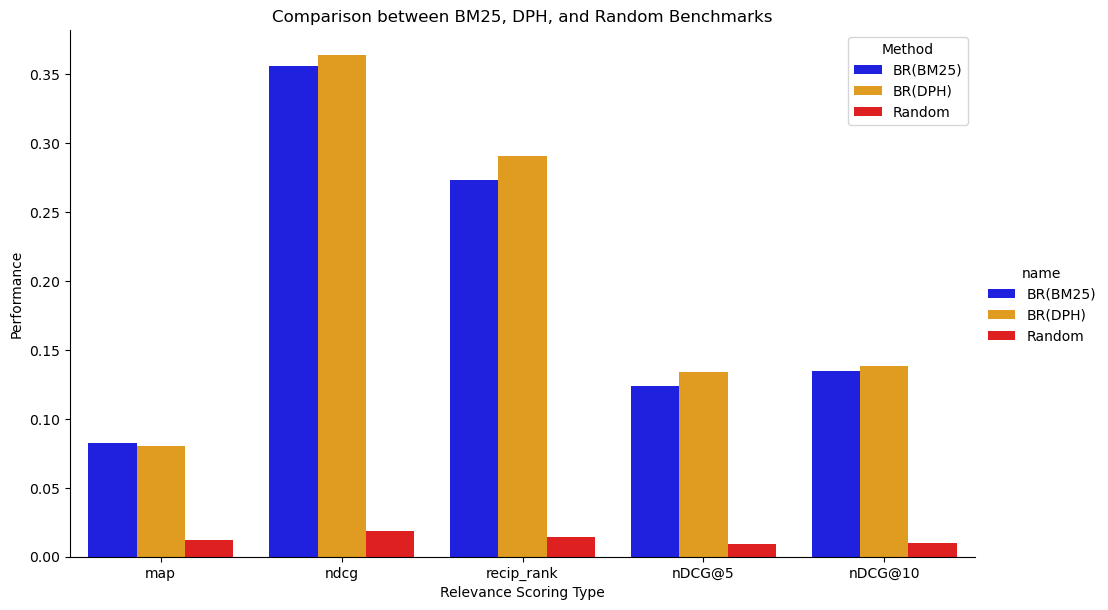

In [28]:
df_long = rel_results.melt(id_vars='name', var_name='Relevance Scoring Type', value_name='Performance')
# Create the plot
sns.catplot(data=df_long, kind='bar', x='Relevance Scoring Type', y='Performance', hue='name', height=6, aspect=10/6, palette=['blue', 'orange', 'red'])

# Customize the plot
plt.title("Comparison between BM25, DPH, and Random Benchmarks")
plt.xlabel("Relevance Scoring Type")
plt.ylabel("Performance")
plt.legend(title='Method')

# Show the plot
plt.show()

### Learn to Rank

In [29]:
KLQE = pt.rewrite.KLQueryExpansion(index)
pipelineQE = bm25 >> KLQE >> bm25
pipelineQE(queries)

,qid,docid,docno,rank,score,query_0,query
0,1,2781,1835339,0,17.211841,hydrating lip balm,applypipeline:off hydrat^1.000000000 lip^1.503...
1,1,1946,2339968,1,16.821952,hydrating lip balm,applypipeline:off hydrat^1.000000000 lip^1.503...
2,1,1628,2288264,2,15.403498,hydrating lip balm,applypipeline:off hydrat^1.000000000 lip^1.503...
3,1,1484,2276574,3,14.787188,hydrating lip balm,applypipeline:off hydrat^1.000000000 lip^1.503...
4,1,2462,2262624,4,14.775416,hydrating lip balm,applypipeline:off hydrat^1.000000000 lip^1.503...
...,...,...,...,...,...,...,...
39995,9,2857,2082766,995,-0.109381,body glow oils and lotions,applypipeline:off bodi^1.366724180 glow^1.0000...
39996,9,1317,2319184,996,-0.118052,body glow oils and lotions,applypipeline:off bodi^1.366724180 glow^1.0000...
39997,9,838,1940725,997,-0.119225,body glow oils and lotions,applypipeline:off bodi^1.366724180 glow^1.0000...
39998,9,1833,2338382,998,-0.137240,body glow oils and lotions,applypipeline:off bodi^1.366724180 glow^1.0000...


In [30]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
pl2 = pt.BatchRetrieve(index, wmodel="PL2")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b5c5d924-388f-42ad-9ea6-87860c96a81b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## Semantic Search

In [48]:
queries['query']

0                          hydrating lip balm
1        mattifying full coverage face primer
2                   korean travel sheet masks
3       skincare products for acne prevention
4                 serum for hyperpigmentation
5                   brightening acne cleanser
6                   cruelty free lip products
7                   white cast free sunscreen
8                  body glow oils and lotions
9                       anti-aging hand cream
10                       hydrating body scrub
11                         hydrating skincare
12               scent free daily moisturizer
13                  color correcting face oil
14                        repairing eye cream
15           acne treatment for hormonal acne
16            christmas gift set for skincare
17                        hydrating face mask
18      night moisturizer for acne prone skin
19               sunscreen for sensitive skin
20                    overnight lip treatment
21                      anti-aging

In [49]:
print(queries)

   qid                                    query
0    1                       hydrating lip balm
1    2     mattifying full coverage face primer
2    3                korean travel sheet masks
3    4    skincare products for acne prevention
4    5              serum for hyperpigmentation
5    6                brightening acne cleanser
6    7                cruelty free lip products
7    8                white cast free sunscreen
8    9               body glow oils and lotions
9   10                    anti-aging hand cream
10  11                     hydrating body scrub
11  12                       hydrating skincare
12  13             scent free daily moisturizer
13  14                color correcting face oil
14  15                      repairing eye cream
15  16         acne treatment for hormonal acne
16  17          christmas gift set for skincare
17  18                      hydrating face mask
18  19    night moisturizer for acne prone skin
19  20             sunscreen for sensiti

In [60]:
queries = pd.read_csv('query_table.csv')
queries['query'] = queries['query'].astype("string")
queries.head()

,qid,query
0,1,hydrating lip balm
1,2,mattifying full coverage face primer
2,3,korean travel sheet masks
3,4,skincare products for acne prevention
4,5,serum for hyperpigmentation


In [105]:
columns = ['qid', 'docno', 'score']
semantic_search_results = pd.DataFrame(columns=columns)

In [106]:
semantic_search_results

,qid,docno,score


In [107]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

corpus = sephora['text']
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

queries_ = queries['query']

top_k = len(corpus)
qid = 0

for query in queries_:
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    
#     print("\n\n======================\n\n")
#     print("Query:", query)
#     print("\nTop 5 most similar sentences in corpus:")
    
#     for score, idx in zip(top_results[0], top_results[1]):
#         idx = idx.item()
#         print(sephora['name'][idx], "(Score: {:.4f})".format(score))
        
    for score, idx in zip(top_results[0], top_results[1]):
        idx = idx.item()
        score = score.item()
        row = pd.DataFrame([{'qid': queries['qid'][qid], 'docno': sephora['docno'][idx], 'score': score}])
        semantic_search_results = pd.concat([semantic_search_results, row], ignore_index=True)

    qid += 1
        


/var/folders/8r/l19_h5xj3dv4qs69ppxdcylh0000gn/T/ipykernel_64874/1178027409.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  semantic_search_results = pd.concat([semantic_search_results, row], ignore_index=True)


In [108]:
print(semantic_search_results)

       qid    docno     score
0        1  2076420  0.754767
1        1  2337657  0.722258
2        1  2270304  0.705289
3        1  2186658  0.686710
4        1  2262624  0.676401
...     ..      ...       ...
137555  40      443  0.026769
137556  40      463  0.018431
137557  40      304  0.016018
137558  40       50 -0.002480
137559  40   698100 -0.015542

[137560 rows x 3 columns]


In [109]:
semantic_search_results.to_csv("semantic_search_results.csv", index=False)

In [110]:
relevance_testing = qrels.copy()

In [112]:
relevance_testing

,qid,docno,label
0,1,2188761,5
1,1,2188860,5
2,1,2327419,4
3,1,1958586,4
4,1,1931518,1
...,...,...,...
1995,40,2262368,5
1996,40,2262483,5
1997,40,2262335,4
1998,40,2262442,5


In [113]:
relevance_testing['map_ideal'] = np.where(relevance_testing['label'] < 3, 0, 1)
relevance_testing

,qid,docno,label,map_ideal
0,1,2188761,5,1
1,1,2188860,5,1
2,1,2327419,4,1
3,1,1958586,4,1
4,1,1931518,1,0
...,...,...,...,...
1995,40,2262368,5,1
1996,40,2262483,5,1
1997,40,2262335,4,1
1998,40,2262442,5,1


In [119]:
semantic_search_results['qid'] = semantic_search_results['qid'].astype('string')
semantic_search_results['docno'] = semantic_search_results['docno'].astype('string')
semantic_search_results.dtypes

qid      string[python]
docno    string[python]
score           float64
dtype: object

In [120]:
relevance_testing.dtypes

qid          string[python]
docno        string[python]
label                 int64
map_ideal             int64
actual              float64
dtype: object

In [121]:
merged_df = pd.merge(relevance_testing, semantic_search_results, on=['docno', 'qid'], how='left')
relevance_testing['actual'] = merged_df['score']

In [123]:
merged_df

,qid,docno,label,map_ideal,actual,score
0,1,2188761,5,1,NaN,0.598915
1,1,2188860,5,1,NaN,0.458508
2,1,2327419,4,1,NaN,0.492338
3,1,1958586,4,1,NaN,0.609236
4,1,1931518,1,0,NaN,0.297549
...,...,...,...,...,...,...
2024,40,2262368,5,1,NaN,0.550331
2025,40,2262483,5,1,NaN,0.450765
2026,40,2262335,4,1,NaN,0.450995
2027,40,2262442,5,1,NaN,0.582461


In [124]:
relevance_testing

,qid,docno,label,map_ideal,actual
0,1,2188761,5,1,0.598915
1,1,2188860,5,1,0.458508
2,1,2327419,4,1,0.492338
3,1,1958586,4,1,0.609236
4,1,1931518,1,0,0.297549
...,...,...,...,...,...
1995,40,2262368,5,1,0.558821
1996,40,2262483,5,1,0.406041
1997,40,2262335,4,1,0.511547
1998,40,2262442,5,1,0.556424


In [127]:
null_counts = relevance_testing.isna().sum()
print(null_counts)
relevance_testing = relevance_testing.dropna()

qid          1
docno        0
label        0
map_ideal    0
actual       4
dtype: int64


In [128]:
average_map_scores = []
average_ndcg_scores = []

for qid, group in relevance_testing.groupby('qid'):
    sorted_group = group.sort_values(by='actual', ascending=False)
    y_true = sorted_group['map_ideal'].tolist()
    y_scores = sorted_group['actual'].tolist()
    average_map_scores.append(average_precision_score(y_true, y_scores))
    relevance_scores = [score for score in y_true]  # Assuming binary relevance
    average_ndcg_scores.append(ndcg_score([relevance_scores], [y_scores]))

average_map = np.mean(average_map_scores)
average_ndcg = np.mean(average_ndcg_scores)

print(f"Average MAP: {average_map}")
print(f"Average NDCG: {average_ndcg}")


Average MAP: 0.5389999588495378
Average NDCG: 0.7753040383058682


/var/folders/8r/l19_h5xj3dv4qs69ppxdcylh0000gn/T/ipykernel_64874/2670988603.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Metric', y='Score', data=df, ci='sd', palette='muted')
/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emanmozaffar/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorical

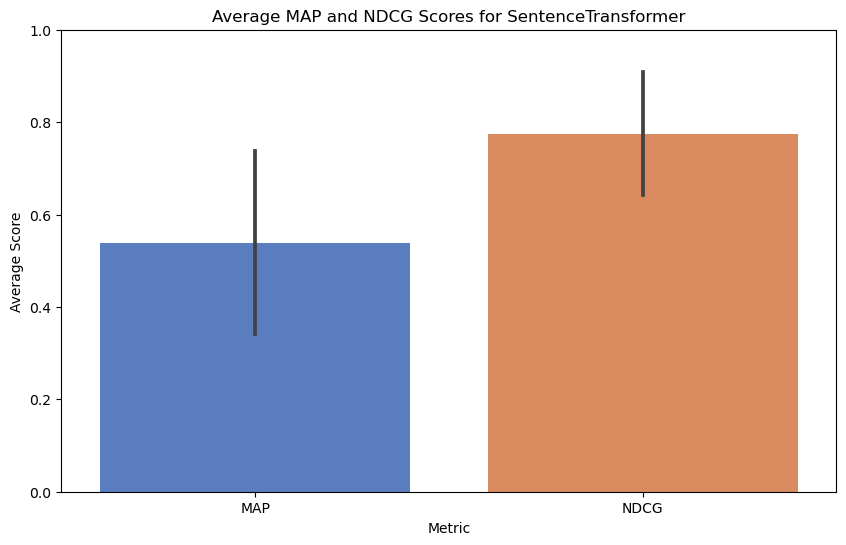

In [131]:
data = {
    'Score': average_map_scores + average_ndcg_scores,
    'Metric': ['MAP'] * len(average_map_scores) + ['NDCG'] * len(average_ndcg_scores)
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=df, ci='sd', palette='muted')

plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.title('Average MAP and NDCG Scores for Semantic Search')
plt.ylim(0, 1)
plt.show()